In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Read all sheets

In [2]:
# Read all sheets into a dictionary
excel_file = "boe-nmg-household-survey-data.xlsx"
all_sheets = pd.read_excel(excel_file, sheet_name=None)


In [3]:
# Access each sheet by its name
for sheet_name, dataframe in all_sheets.items():
    print(f"Sheet Name: {sheet_name}")

Sheet Name: Instructions
Sheet Name: Data description
Sheet Name: 2011-2023 PID-SUBSID
Sheet Name: 2011
Sheet Name: 2012
Sheet Name: 2013
Sheet Name: 2014
Sheet Name: 2015
Sheet Name: 2016
Sheet Name: 2017
Sheet Name: 2018
Sheet Name: 2019
Sheet Name: 2020
Sheet Name: 2021
Sheet Name: 2022
Sheet Name: 2023


In [4]:
# Concatenate sheets
exclude_sheets = ["Instructions", "Data description", "2011-2023 PID-SUBSID"]

combined_df = pd.concat(
    [df.assign(year=sheet_name) for sheet_name, df in all_sheets.items() if sheet_name not in exclude_sheets],
    ignore_index=True
)

combined_df.head()

,we_factor,subsid,dsoc,dsocial,fgenage_1,dage,dregion,fgen,qhousing,dhousing,...,spq14d_rank_2,spq14d_rank_3,spq14d_rank_4,spq14d_rank_970,boe93_1,boe93_2,boe93_3,boe93_4,boe93_5,boe93_na
0,1.176425,22007620.0,2.0,1.0,23,1,3,2,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.931040,22238715.0,5.0,5.0,22,1,3,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.181808,20404925.0,2.0,1.0,59,5,3,1,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.000213,21839916.0,5.0,5.0,21,1,9,1,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.913671,23091998.0,4.0,4.0,24,1,1,2,4,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Initial processing

1957 total columns
1582 cols have >90% missing values
1921 cols have >20% missing values


In [5]:
# Assess missing values - print 20 cols with most missing vals
missing_summary = combined_df.isnull().mean().sort_values(ascending=False)
print(missing_summary.head(20))

be10b_hidden          0.999986
mg2_rank_8            0.999972
BOE87_bandsv1v2_13    0.999972
spq14b_rank_10        0.999972
boe87incomev2_13      0.999972
BOE87_bandsv1v2_7     0.999958
boe87incomev2_7       0.999958
spq14b_rank_11        0.999958
BOE87_bandsv1v2_3     0.999944
boe87incomev2_3       0.999944
spq14b_rank_9         0.999930
boe87incomev2_99      0.999930
BOE87_bandsv1v2_99    0.999930
BOE87_bandsv1v2_12    0.999930
boe87incomev2_12      0.999930
SPQ09C_6              0.999930
spq14b_rank_2         0.999930
spq14b_rank_4         0.999916
spq14b_rank_1         0.999916
bod73_9               0.999902
dtype: float64


In [6]:
# Calculate the proportion of missing values for each column
missing_proportions = combined_df.isnull().mean()

columns_with_high_missing = missing_proportions[missing_proportions > 0.2]
count_high_missing = len(columns_with_high_missing)

print(f"Number of columns with more than 90% missing data: {count_high_missing}")

Number of columns with more than 90% missing data: 1921


In [44]:
# Check blanks and non-blanks for 'qincome' column across each year
blank_non_blank_summary = combined_df.groupby('year')['qincomefree_1'].apply(
    lambda x: pd.Series({
        'Blanks': x.isnull().sum(),
        'Non-Blanks': x.notnull().sum()
    })
).unstack()

# Display the summary
print(blank_non_blank_summary)

      Blanks  Non-Blanks
year                    
2011     995           0
2012    4003           0
2013    3355        2651
2014    1719        4282
2015    3739        2268
2016    6011           0
2017    6018           0
2018    6000           0
2019    6051           0
2020    6032           0
2021    6051           0
2022    6053           0
2023    5914           0


## Research ideas

- To what extent have household budgets and spending decisions changed/recovered since Covid

- Future outlook (future income, uncertainty, savings intentions)
- Household budget
- Savings rate
- Debt level
- Type of debt (secured vs unsecured)
- Income
- Housing tenure (owners, mortgages and renters) - I like the idea of segregating this and analysing the impact of housing on young people's prospects.

External data sources
- Inflation rate
- Interest rate
- Unemp rate
- GDP

## Housing

In [18]:
combined_df.groupby('year')['dhousing'].value_counts()

year  dhousing
2011  1            382
      2            344
      4            131
      3            123
      98            15
                  ... 
2023  2           2180
      1           1600
      4           1051
      3           1043
      98            40
Name: count, Length: 65, dtype: int64

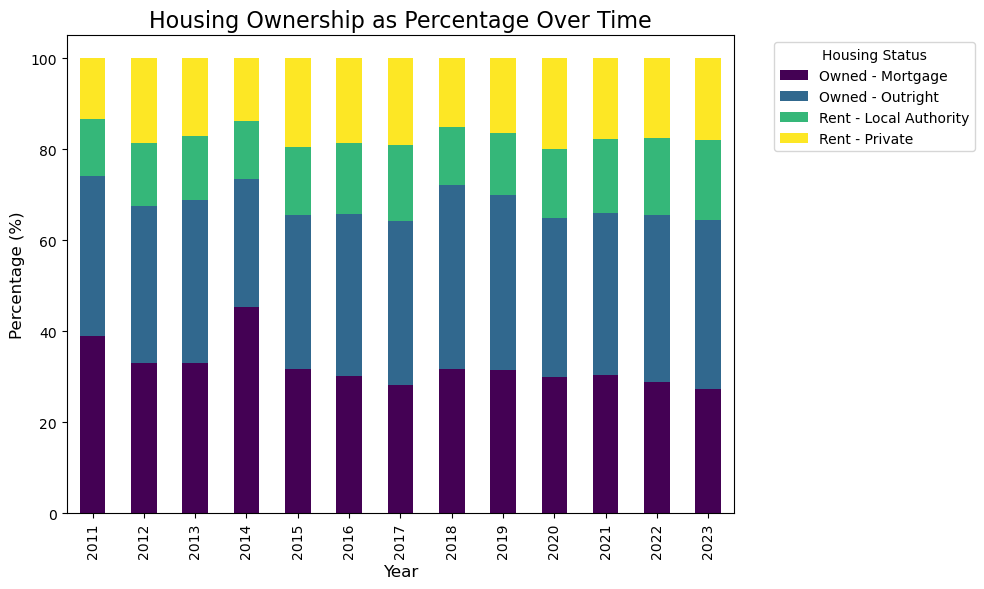

In [9]:
# Create a count of occurrences for each Housing_Status per Year
pivot_table = combined_df.groupby(['year', 'dhousing']).size().unstack(fill_value=0)

# Remove code 98 from the data
pivot_table.drop(columns=[98], inplace=True, errors='ignore')  # Drop column 98 if it exists

# Normalize the pivot table to percentages (row-wise)
percentage_table = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

# Relabel the columns for better readability
housing_labels = {
    1: "Owned - Mortgage",
    2: "Owned - Outright",
    3: "Rent - Local Authority",
    4: "Rent - Private"
}
percentage_table.rename(columns=housing_labels, inplace=True)

# Plotting the stacked bar chart
percentage_table.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6),
    colormap='viridis'
)

# Adding labels and title
plt.title('Housing Ownership as Percentage Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Housing Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Display the plot
plt.show()

In [20]:
print(percentage_table)

dhousing  Owned - Mortgage  Owned - Outright  Rent - Local Authority  \
year                                                                   
2011             38.979592         35.102041               12.551020   
2012             33.062880         34.533469               13.691684   
2013             33.016304         35.716712               14.249321   
2014             45.303030         28.164983               12.811448   
2015             31.797545         33.680847               15.032790   
2016             30.252101         35.495798               15.512605   
2017             28.086316         36.032118               16.694547   
2018             31.744966         40.436242               12.718121   
2019             31.542173         38.346365               13.691565   
2020             30.023364         34.946595               15.136849   
2021             30.277824         35.601397               16.353352   
2022             28.904041         36.554133               16.88

## Income 

In [17]:
print(f"qincome - blank values: {combined_df['qincome'].isnull().sum()}")
print(f"qincome - non-blank values: {combined_df['qincome'].notnull().sum()}")
print(f"qincomev1 - blank values: {combined_df['qincomev1'].isnull().sum()}")
print(f"qincomev1 - non-blank values: {combined_df['qincomev1'].notnull().sum()}")

qincome - blank values: 54137
qincome - non-blank values: 17005
qincomev1 - blank values: 68012
qincomev1 - non-blank values: 3130


In [29]:
income_labels = {
    1: "Up to £4,499",
    2: "£4,500 - £6,499",
    3: "£6,500 - £7,499",
    4: "£7,500 - £9,499",
    5: "£9,500 - £11,499",
    6: "£11,500 - £13,499",
    7: "£13,500 - £15,499",
    8: "£15,500 - £17,499",
    9: "£17,500 - £24,999",
    10: "£25,000 - £29,999",
    11: "£30,000 - £39,999",
    12: "£40,000 - £49,999",
    13: "£50,000 - £74,999",
    14: "£75,000 - £99,999",
    15: "£100,000 or more",
    97: "Don't know",
    96: "Prefer not to state"
}

# Replace numerical codes with labels
combined_df['qincome-range'] = combined_df['qincome'].map(income_labels)

# Define midpoints for each income range
income_midpoints = {
    1: 2250,
    2: 5500,
    3: 7000,
    4: 8500,
    5: 10500,
    6: 12500,
    7: 14500,
    8: 16500,
    9: 21000,
    10: 27500,
    11: 35000,
    12: 45000,
    13: 62500,
    14: 87500,
    15: 100000,  # Lower bound for "£100,000 or more"
    96: None,  # Exclude "Prefer not to state"
    97: None   # Exclude "Don't know"
}

# Add a column for midpoint income values
combined_df['qincome-midpoint'] = combined_df['qincome'].map(income_midpoints)

/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_5040/2561008459.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['qincome-midpoint'] = combined_df['qincome'].map(income_midpoints)


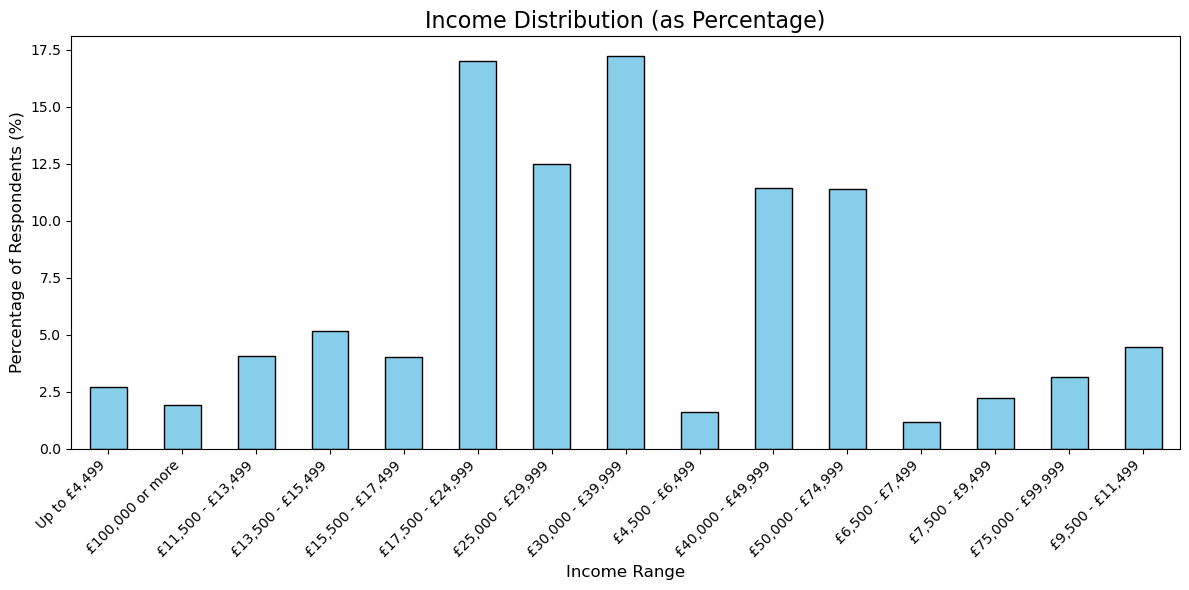

In [30]:
# Exclude non-informative responses
df_filtered = combined_df[~combined_df['qincome-range'].isin(["Don't know", "Prefer not to state"])]

# Calculate the percentage distribution
income_distribution = df_filtered['qincome-range'].value_counts(normalize=True) * 100

# Sort income categories for a logical order
income_distribution = income_distribution.sort_index()

# Plot the distribution as a bar chart
plt.figure(figsize=(12, 6))
income_distribution.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Income Distribution (as Percentage)', fontsize=16)
plt.xlabel('Income Range', fontsize=12)
plt.ylabel('Percentage of Respondents (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

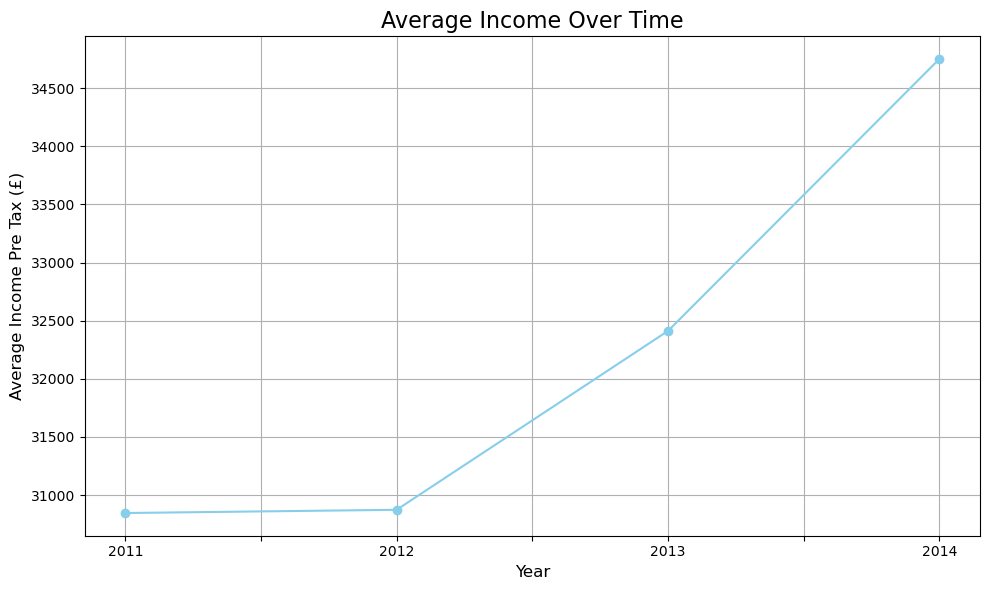

In [38]:
# Group by Year and calculate average income
average_income_per_year = df_filtered.groupby('year')['qincome-midpoint'].mean()

# Plot the trend over time
plt.figure(figsize=(10, 6))
average_income_per_year.plot(kind='line', marker='o', color='skyblue')
plt.title('Average Income Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Income Pre Tax (£)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/wc/c52q6ldd5svg672hjnv1bt3m0000gn/T/ipykernel_5040/3291534506.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['dhousing-labels'] = df_filtered['dhousing'].map(housing_labels)


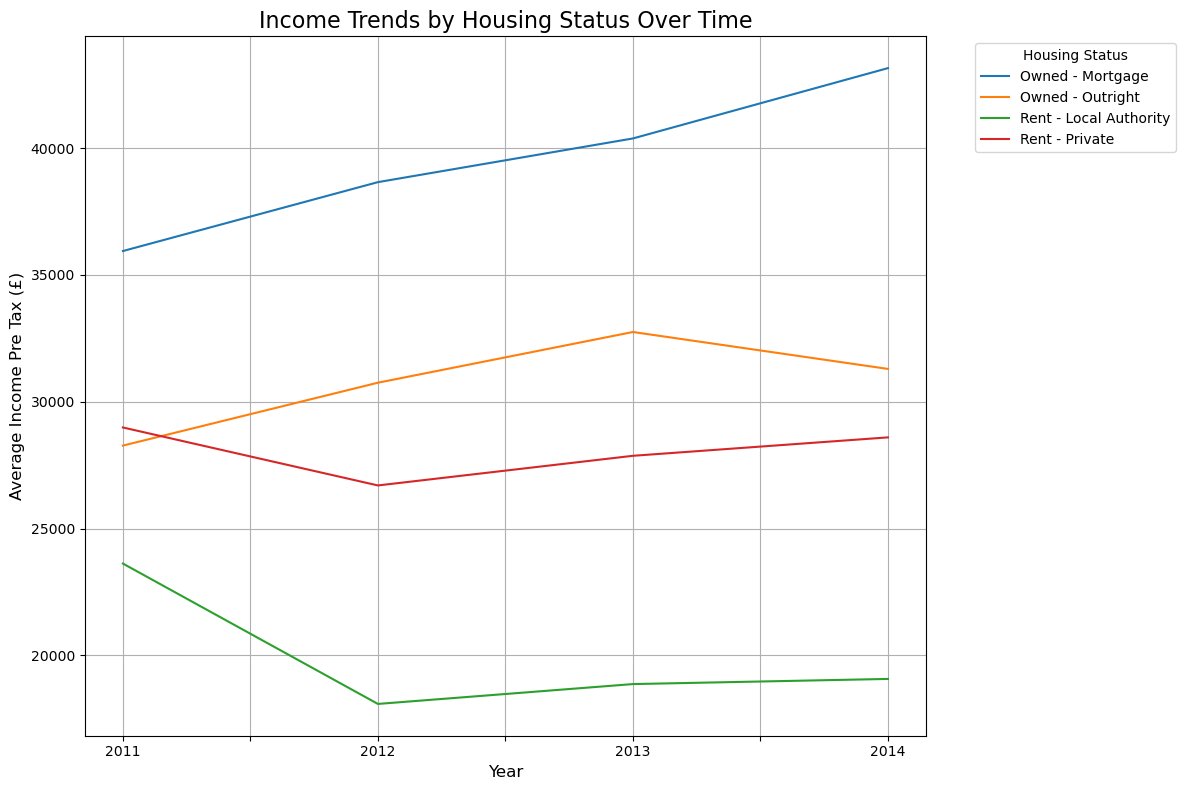

In [35]:
# Define the new housing labels
housing_labels = {
    1: "Owned - Mortgage",
    2: "Owned - Outright",
    3: "Rent - Local Authority",
    4: "Rent - Private"
}

# Map the new labels to the 'Housing_Status' column
df_filtered['dhousing-labels'] = df_filtered['dhousing'].map(housing_labels)

# Group by Year and Housing Status to calculate average income
income_trends_by_group = df_filtered.groupby(['year', 'dhousing-labels'])['qincome-midpoint'].mean().unstack()

# Plot income trends for each group
income_trends_by_group.plot(kind='line', figsize=(12, 8))
plt.title('Income Trends by Housing Status Over Time', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Income Pre Tax (£)', fontsize=12)
plt.legend(title='Housing Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()